# **Explaining Portuguese exam results using PVI**

The goal of this homework was to explain the results of students from their lifestyles and life situations. Similarly to the previous homework, I use the Portuguese dataset only. For explanations I use PVI from the dalex module. I found that permuting the column with failures makes the biggest difference. Surprisingly, number of failures doesn't seem to be such an important variable in xgboost training. 

### **Subtask 1**
In this subtask I selected XGBoost model, with quite a lot of estimators and big maximal depth. The PVI is visible below:

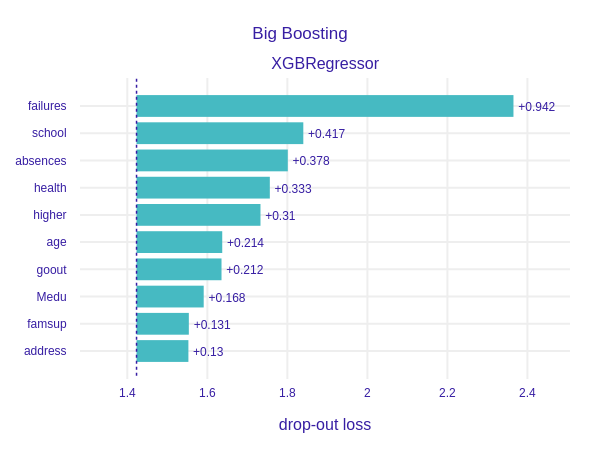

Similarly to previous homeworks, we can observe that the number of previous failures is the most important feature.

### **Subtask 2**
I compare the "big" XGBoost model to an XGBoost model with more limited depth and numbers of estimators. Analogously I also compare them to "big" Random Forest model and "small" random forest model. The difference in performance of those models can be to an extent inferred from the below plots:

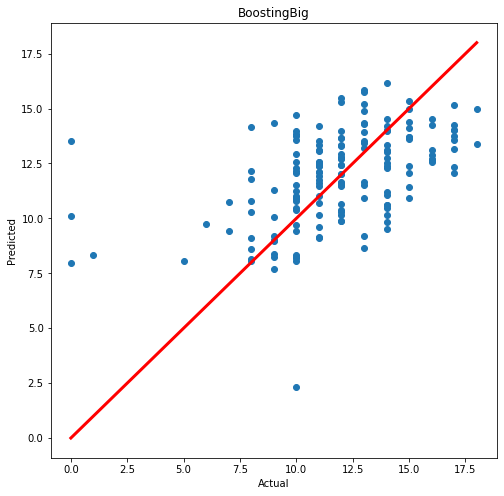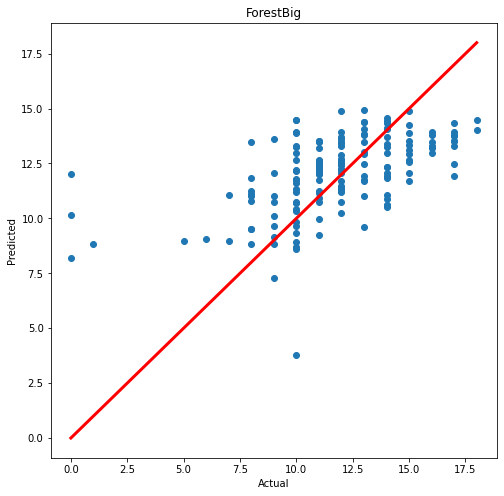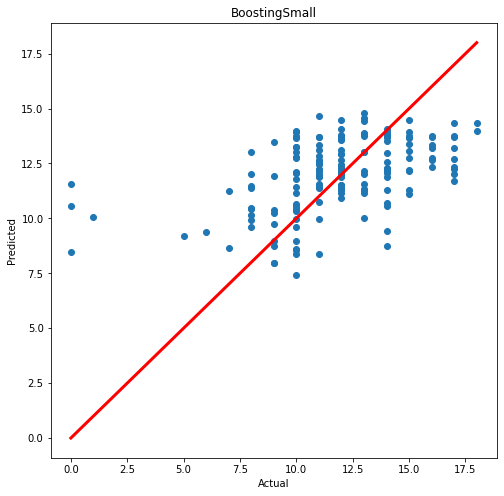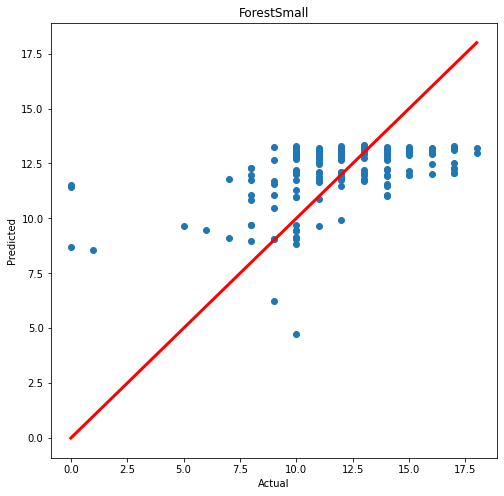

From the plots below it is clearly visible that the number of failures is the most important feature. Moreover the two most important variables are actually the same. While that the small random forest model relies mostly on the failures variable, which would potentially agree with the fact, that it's not working very well for the students with high scores (who aren't differentiated by the number of failures). I believe, that the mother's/father's education influence is underestimated here - because those variables are very strongly correlated. 

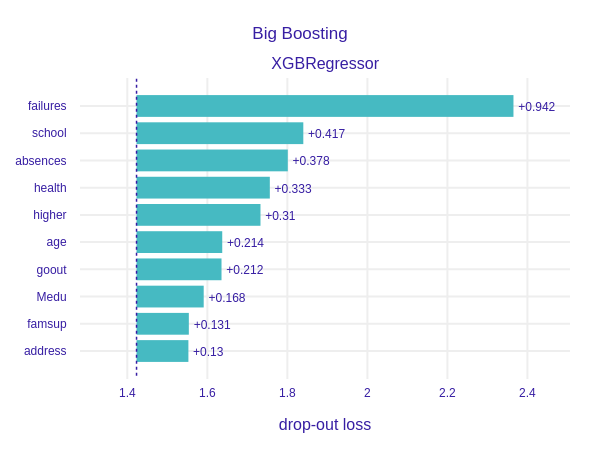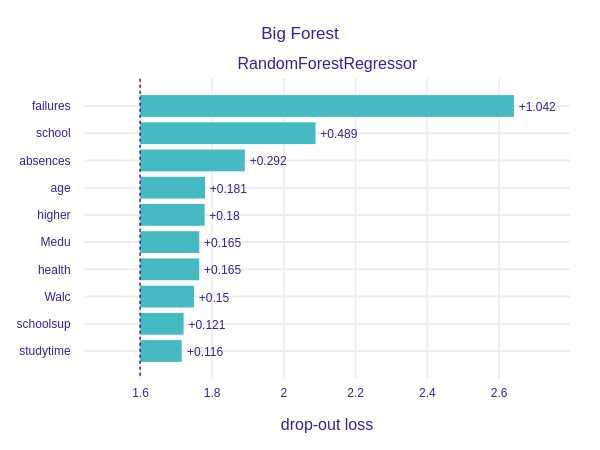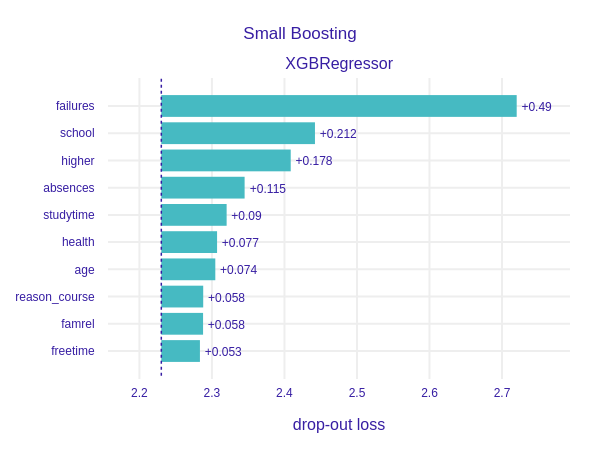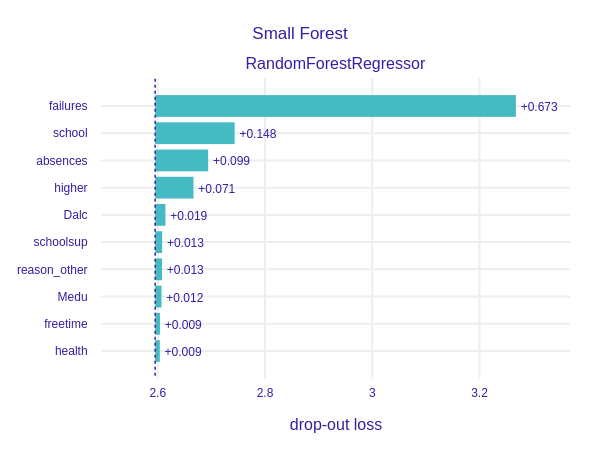

### **Subtask 3**


For some reason, the three ways to measure feature importance are quite a bit different. When looking at the feature importance given by xgboost, number of failures isn't even present in the top ten features. In SHAP and PVI, the number of failures is the most important. Moreover, the most important features don't differ that much between PVI and SHAP - they are just a bit shuffled, but the ones in the importance from XGBoost are quite significantly different. Those differences are particularly visible when looking at the features such as the aforementioned failures, but also sex and whether a child wants higher education. 

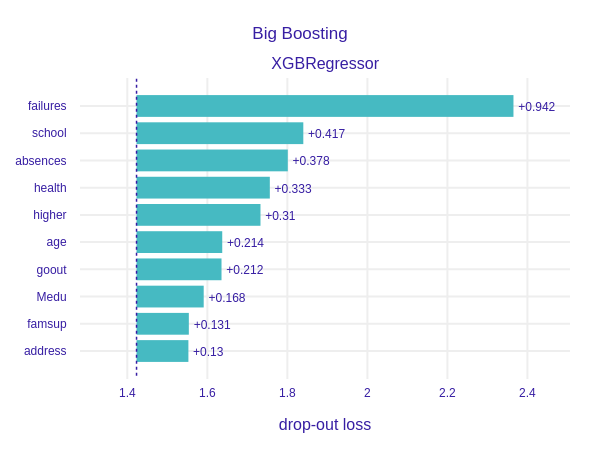
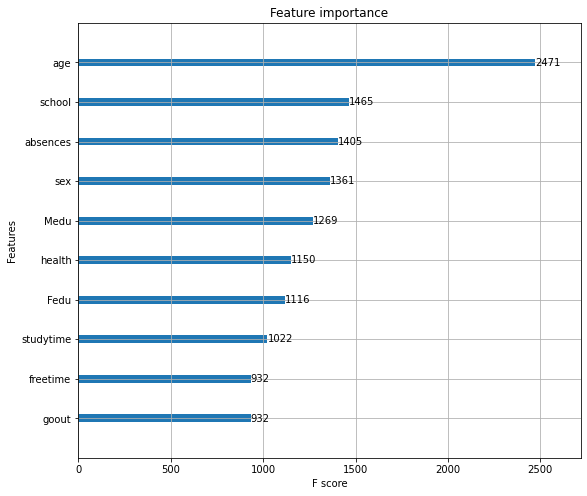
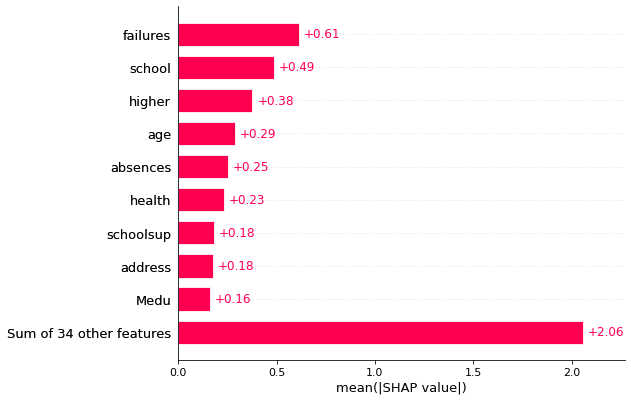

## **Appendix**
Contains the Python code used to create the above raport


# **Dataset**
This dataset contains the data about the scores of students of two different school in Portugal in math and Portuguese. The goal is to predict the final score of a student, using information about their lifestyle and background. I am going to focus only on predicting G3 - according to the description of the problem G1 and G2 are highly correlated with G3.  

### **Imports**
We need to install the necessary modules.

In [6]:
!pip install dalex
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


And now import everything that is necessary.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dalex as dx
import shap
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from xgboost import plot_importance 

Set the seeds for reproducibility.

In [8]:
np.random.seed(10)
random.seed(10)

### **Data preparation**
We will start by reading the data.

In [9]:
portuguese_df = pd.read_csv('Portuguese.csv')

Split into features and targets. The same as in the previous homework, we focus on predicting the final result only.

In [10]:
port_x = portuguese_df.drop(['G3', 'G2', 'G1'], axis = 1)
port_y = portuguese_df[['G3']]

Categorical variables need to be encoded.

In [11]:
def encode_categorical(df):
    df = df.copy()
    
    df = df.replace({'GP': 0, 'MS': 1})
    df = df.replace({'F': 0, 'M': 1})
    df = df.replace({'U': 0, 'R': 1})
    df = df.replace({'LE3': 0, 'GT3': 1})
    df = df.replace({'A': 0, 'T': 1})
    df = df.replace({'no': 0, 'yes': 1})
    
    onehot_features = ['Mjob', 'Fjob', 'reason', 'guardian']
    df = pd.concat([df, pd.get_dummies(df[onehot_features])], axis=1)
    df = df.drop(onehot_features, axis=1)

    return df

In [12]:
port_x = encode_categorical(port_x)

Splitt the dataset into train and test sets.

In [13]:
port_x_train, port_x_test, port_y_train, port_y_test = train_test_split(port_x, port_y)

In [14]:
print(port_y_train)

     G3
489  10
229  15
644  10
109  14
116  16
..   ..
369  11
320  13
527  10
125   9
265  15

[486 rows x 1 columns]


## **Homework implementation**
Below the code used for solving each of the required homework tasks is contained. Only XGBoost is used with the exception of the subtask 7.

### **Subtask 0**

We train two models XGBoost and random forest model. We train on the whole dataset, since there isn't much data and it shouldn't matter for the explanations.

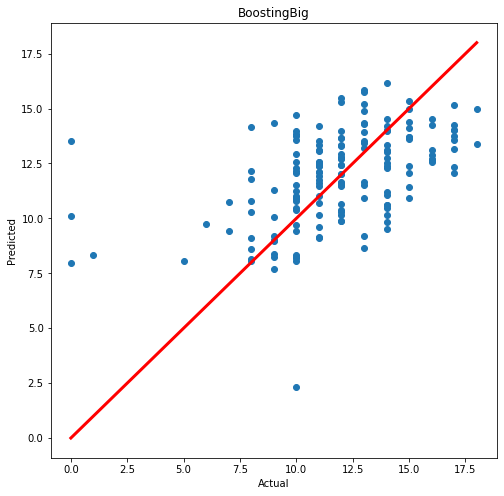

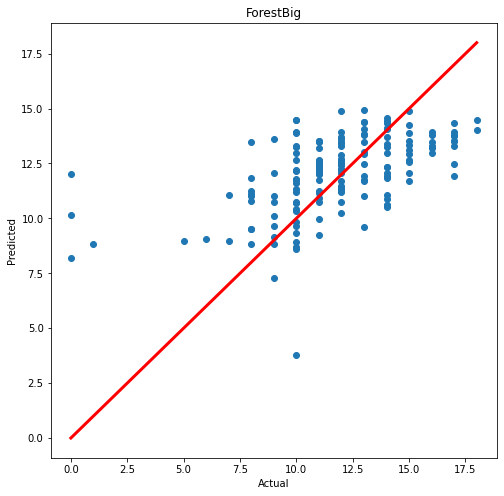

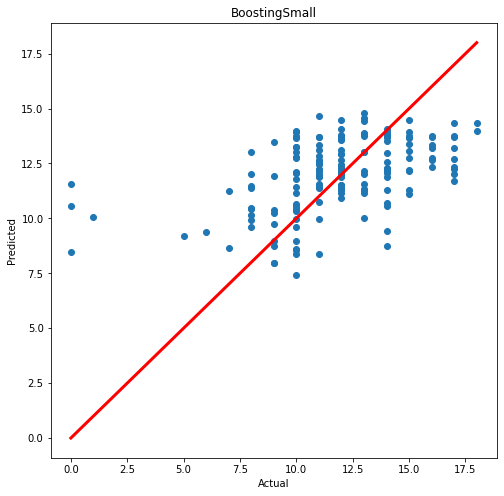

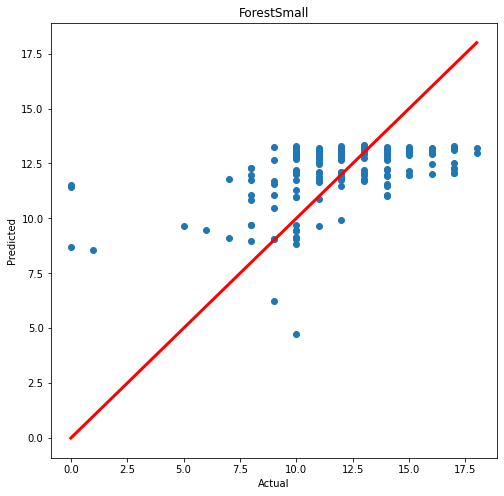

In [15]:
models = {
    'BoostingBig': XGBRegressor(objective='reg:squarederror', max_depth=10, n_estimators=1000),
    'ForestBig': RandomForestRegressor(max_depth=None, n_estimators=1000),
    'BoostingSmall': XGBRegressor(objective='reg:squarederror', max_depth=3, n_estimators=50),
    'ForestSmall': RandomForestRegressor(max_depth=3, n_estimators=50)
  }

for name, model in models.items():
    model.fit(port_x_train, port_y_train.values.ravel())
    y_pred = model.predict(port_x_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(port_y_test, y_pred)
    plt.plot([port_y_test.min(), port_y_test.max()], [port_y_test.min(), port_y_test.max()], c='r', lw=3)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(name)
    plt.show()

### **Subtask 1**
Calculating permutation-based variable importance.

In [16]:
explainers = [dx.Explainer(model, port_x_test, port_y_test) for model in models.values()]
print([explainer.model_performance() for explainer in explainers])

Preparation of a new explainer is initiated

  -> data              : 163 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 163 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f68f7724160> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 2.32, mean = 11.9, max = 16.2
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -13.5, mean = -0.12, max = 7.68
  -> model_info        : package xgboost

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 163 rows 43 cols
  -> target variable   : Parameter 'y' was 

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.78, mean = 12.1, max = 14.9
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -12.0, mean = -0.288, max = 6.22
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 163 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 163 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f68f7724160> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 7.44, mean = 12.0, max = 14.8

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [17]:
pvis = [explainer.model_parts(random_state=0) for explainer in explainers]
print([pvi.result for pvi in pvis])

[             variable  dropout_loss         label
0            absences      2.779757  XGBRegressor
1         Mjob_health      2.813174  XGBRegressor
2          traveltime      2.814843  XGBRegressor
3   reason_reputation      2.816300  XGBRegressor
4                Fedu      2.822079  XGBRegressor
5        Fjob_teacher      2.823373  XGBRegressor
6              famsup      2.829546  XGBRegressor
7        Mjob_teacher      2.831700  XGBRegressor
8            freetime      2.833835  XGBRegressor
9            romantic      2.834530  XGBRegressor
10     guardian_other      2.834643  XGBRegressor
11       Mjob_at_home      2.835075  XGBRegressor
12            famsize      2.835248  XGBRegressor
13         activities      2.835961  XGBRegressor
14      Mjob_services      2.836264  XGBRegressor
15    guardian_mother      2.837808  XGBRegressor
16       _full_model_      2.839480  XGBRegressor
17       reason_other      2.839939  XGBRegressor
18         Fjob_other      2.840076  XGBRegressor

In [18]:
titles = ["Big Boosting", "Big Forest", "Small Boosting", "Small Forest"]
pvis[0].plot(show=False).update_layout(autosize=False, width=600, height=450, title=titles[0])

In [19]:
pvis[1].plot(show=False).update_layout(autosize=False, width=600, height=450, title=titles[1])

In [20]:
pvis[2].plot(show=False).update_layout(autosize=False, width=600, height=450, title=titles[2])

In [21]:
pvis[3].plot(show=False).update_layout(autosize=False, width=600, height=450, title=titles[3])

### **Subtask 3**
Comparing with other methods for calculating feature immportance.

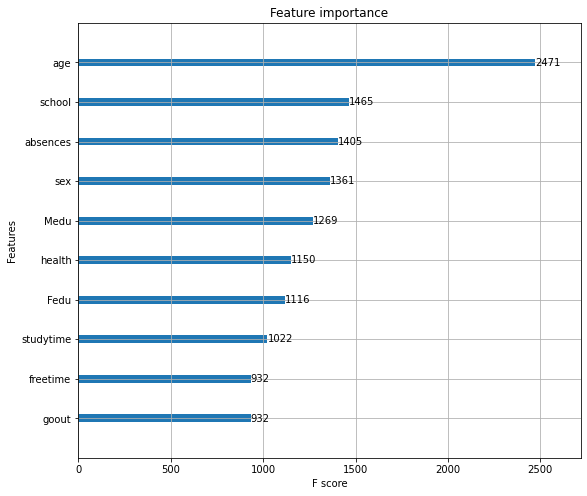

In [22]:
plt.rcParams["figure.figsize"] = (9, 8)
plot_importance(models["BoostingBig"], max_num_features=10)
plt.show()

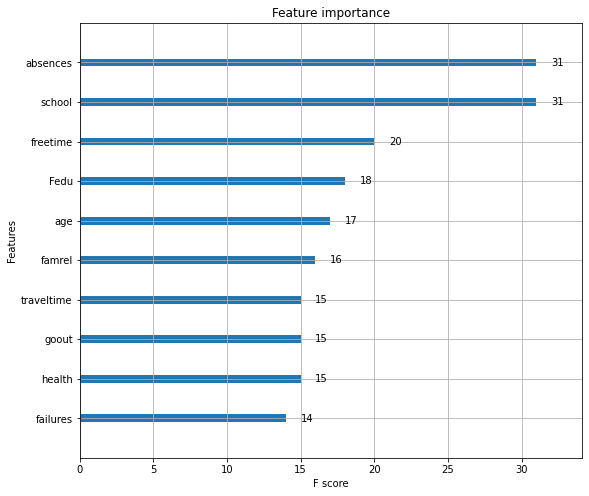

In [23]:
plot_importance(models["BoostingSmall"], max_num_features=10)
plt.show()

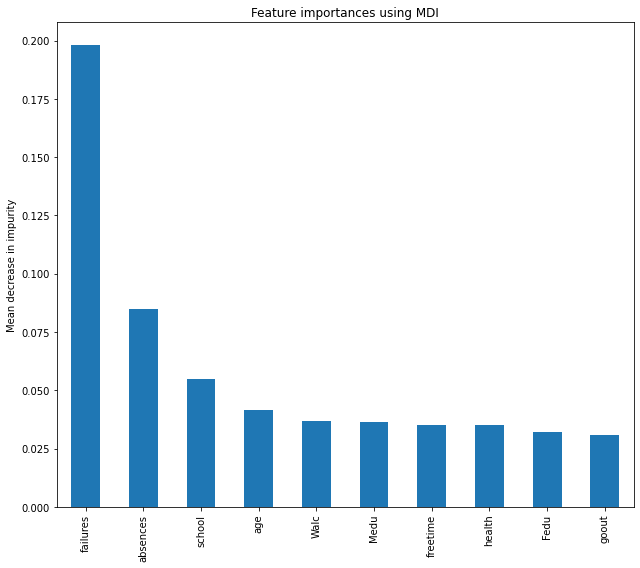

In [24]:
importances = models["ForestBig"].feature_importances_
forest_importances = pd.Series(importances, index=list(port_x.columns)).sort_values(axis=0, ascending=False)[:10]

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

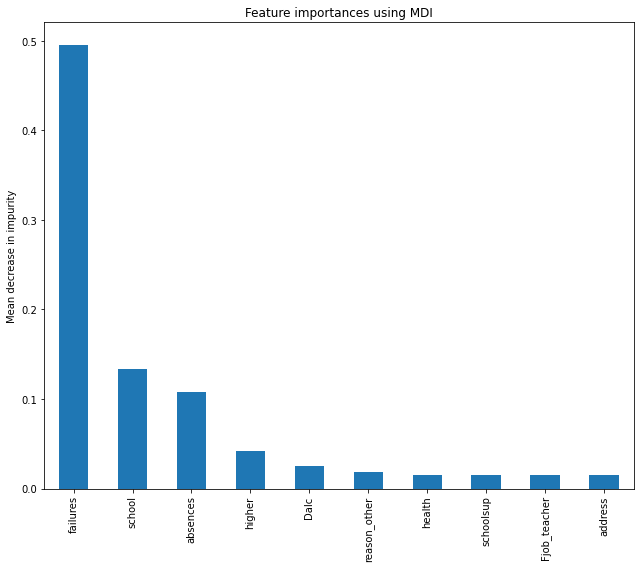

In [25]:
importances = models["ForestSmall"].feature_importances_
forest_importances = pd.Series(importances, index=list(port_x.columns)).sort_values(axis=0, ascending=False)[:10]

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

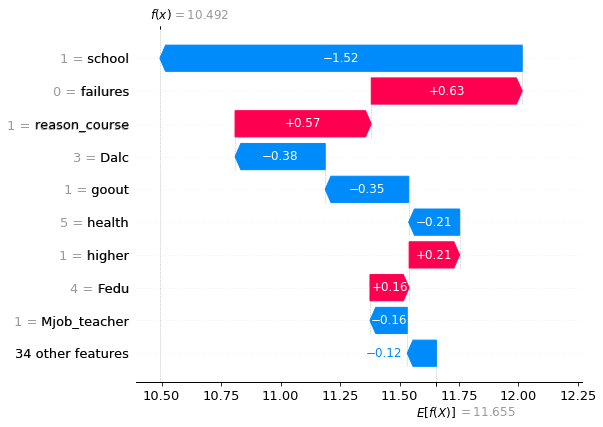

In [26]:
shap_explainer = shap.explainers.Tree(models["BoostingBig"], data=port_x_test)
shap_values = shap_explainer(port_x_test.iloc[[4]])
shap.plots.waterfall(shap_values[0])

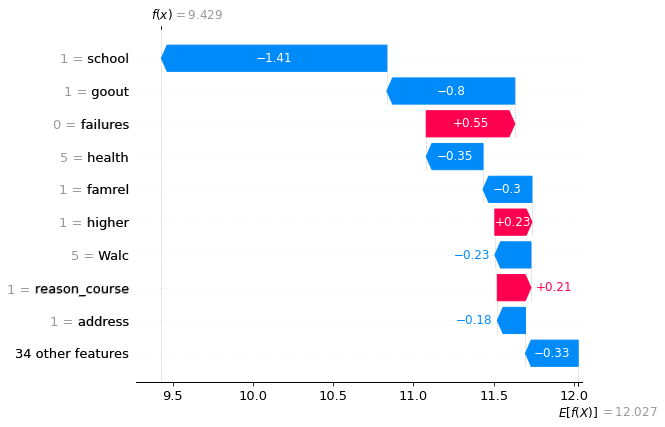

In [27]:
shap_explainer = shap.explainers.Tree(models["BoostingSmall"], data=port_x_test)
shap_values = shap_explainer(port_x_test.iloc[[4]])
shap.plots.waterfall(shap_values[0])

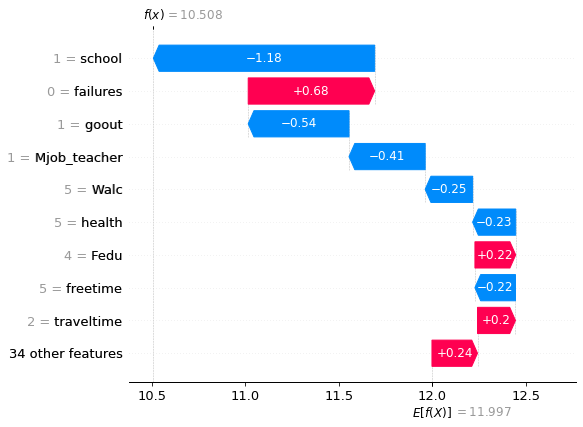

In [28]:
shap_explainer = shap.explainers.Tree(models["ForestBig"], data=port_x_test)
shap_values = shap_explainer(port_x_test.iloc[[4]])
shap.plots.waterfall(shap_values[0])

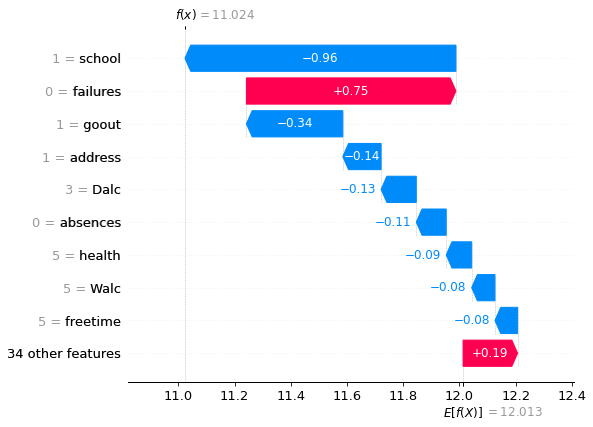

In [29]:
shap_explainer = shap.explainers.Tree(models["ForestSmall"], data=port_x_test)
shap_values = shap_explainer(port_x_test.iloc[[4]])
shap.plots.waterfall(shap_values[0])

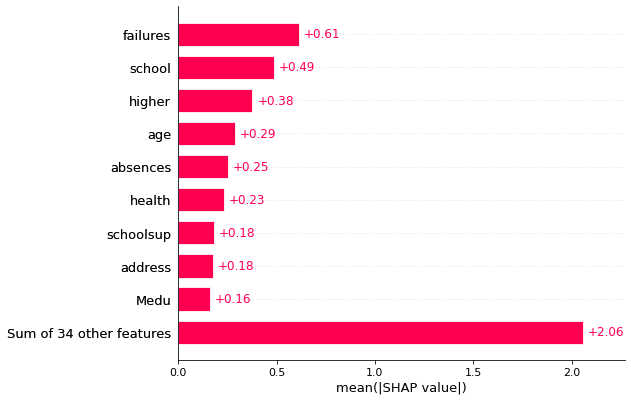

In [36]:
shap_explainer = shap.explainers.Tree(models["BoostingBig"], data=port_x_test)
shap_values = shap_explainer(port_x_test)
shap.plots.bar(shap_values)